In [1]:
#Antimicrobial peptide classification example(yet again)
#Data from : https://github.com/zhanglabNKU/APIN/blob/master/


import Bio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from keras.layers import Dense, Dropout, Embedding, Layer, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Input
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from Bio import SeqIO

# Sample peptide sequences (with variable lengths)
amps_tr=[]
amps_te=[]
amps_val=[]
decoy_tr=[]
decoy_te=[]
decoy_val=[]

y_tr=[]
y_te=[]
y_val=[]


for sequence in SeqIO.parse('AMP.tr.fa', "fasta"):
    amps_tr.append(str(sequence.seq))
    y_tr.append(1)
    
for sequence in SeqIO.parse('AMP.te.fa', "fasta"):
    amps_te.append(str(sequence.seq))
    y_te.append(1)    
    
for sequence in SeqIO.parse('AMP.eval.fa', "fasta"):
    amps_val.append(str(sequence.seq))
    y_val.append(1)    
    
for sequence in SeqIO.parse('DECOY.tr.fa', "fasta"):
    decoy_tr.append(str(sequence.seq))
    y_tr.append(0)

for sequence in SeqIO.parse('DECOY.te.fa', "fasta"):
    decoy_te.append(str(sequence.seq))
    y_te.append(0)    

for sequence in SeqIO.parse('DECOY.eval.fa', "fasta"):
    decoy_val.append(str(sequence.seq))
    y_val.append(0)    
    
amps_tr.extend(decoy_tr)
amps_tr.extend(amps_te)
amps_tr.extend(decoy_te)
amps_tr.extend(amps_val)
amps_tr.extend(decoy_val)

y_tr.extend(y_te)
y_tr.extend(y_val)

X=amps_tr
y=y_tr

peptide_sequences=list(X)
targets=list(y)

In [3]:
# Define amino acid vocabulary
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # 20 standard amino acids
vocab_size = len(amino_acids)
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

# Function to one-hot encode peptide sequences
max_sequence_length = max([len(i) for i in peptide_sequences])  # Set this to the maximum sequence length during training

# Updated one-hot encoding function with padding
def one_hot_encode_sequences(sequences, max_length):
    # Initialize an array with zeros for one-hot encoding
    encoded = np.zeros((len(sequences), max_length, vocab_size), dtype=int)
    
    for i, seq in enumerate(sequences):
        for j, aa in enumerate(seq):
            if j >= max_length:  # Avoid exceeding the max length
                break
            if aa in aa_to_index:  # Ensure the amino acid is valid
                encoded[i, j, aa_to_index[aa]] = 1
            else:
                raise ValueError(f"Invalid amino acid '{aa}' found in sequence '{seq}'.")

    return encoded

In [4]:
# Example peptide sequences
encoded_sequences = one_hot_encode_sequences(peptide_sequences, max_sequence_length)

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(encoded_sequences, targets, test_size=0.2, random_state=42)

In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Transformer Block remains unchanged
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

# Model Creation without TokenAndPositionEmbedding
def create_model(embed_dim, num_heads, ff_dim, vocab_size, max_length=183):
    inputs = Input(shape=(max_length, vocab_size))  # Fixed max_length input
    # Directly create the embedding layer
    token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(tf.argmax(inputs, axis=-1))
    # Create positional encodings
    positions = tf.range(start=0, limit=max_length)
    position_emb = layers.Embedding(input_dim=max_length, output_dim=embed_dim)(positions)
    
    # Combine token and positional embeddings
    x = token_emb + position_emb  # Broadcasting the positional embedding

    # Pass through the transformer block
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [41]:
# Model parameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in the feed-forward network

# Create and compile the model
model = create_model(embed_dim=64, num_heads=4, ff_dim=128, vocab_size=vocab_size)
model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
356/356 [==============================] - 67s 183ms/step - loss: 0.5418 - accuracy: 0.6906 - val_loss: 0.3324 - val_accuracy: 0.8722
Epoch 2/5
356/356 [==============================] - 66s 186ms/step - loss: 0.3363 - accuracy: 0.8695 - val_loss: 0.3142 - val_accuracy: 0.8820
Epoch 3/5
356/356 [==============================] - 82s 231ms/step - loss: 0.3279 - accuracy: 0.8748 - val_loss: 0.2972 - val_accuracy: 0.8919
Epoch 4/5
356/356 [==============================] - 63s 177ms/step - loss: 0.3321 - accuracy: 0.8748 - val_loss: 0.2852 - val_accuracy: 0.8890
Epoch 5/5
356/356 [==============================] - 56s 155ms/step - loss: 0.3178 - accuracy: 0.8801 - val_loss: 0.2971 - val_accuracy: 0.8904


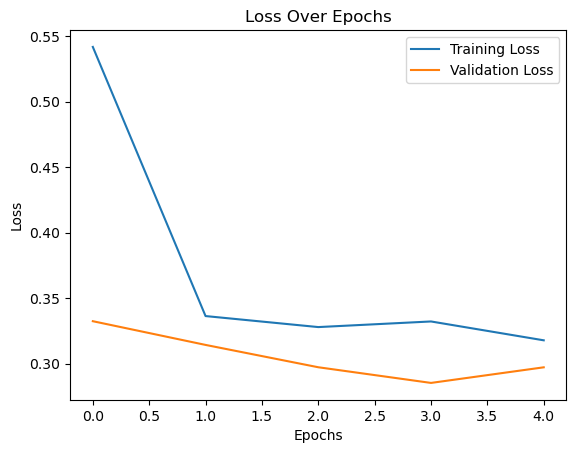

In [42]:
# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

23/23 [==============================] - 4s 140ms/step - loss: 0.2971 - accuracy: 0.8904


In [44]:
print('Test accuracy: '+ str((round((test_accuracy)*100,2)))+'%')

Test accuracy: 89.04%


In [47]:
# Example new sequence for prediction
new_sequence = ['ACDEFGHIKCA']  # Your new sequence to predict on

# One-hot encode the new sequence with padding to max_sequence_length
encoded_new_sequence = one_hot_encode_sequences(new_sequence, max_sequence_length)

# Make prediction (the model expects a batch of sequences)
prediction = model.predict(encoded_new_sequence)

# Print the prediction result
print("Prediction probability:", prediction)

Prediction probability: [[0.88548964]]


In [53]:
binary_prediction = (prediction >= 0.5).astype(int)

print("Binary prediction:", binary_prediction)

Binary prediction: [[1]]


In [48]:
model.save("peptide_transformer_model.h5")

In [50]:
#Load model

loaded_model = load_model("peptide_transformer_model.h5", custom_objects={
    "TransformerBlock": TransformerBlock,
})

# Optionally freeze Transformer Block layer for finetuning. 
#Could be applied to the name-generator model as well

for layer in loaded_model.layers:
    if isinstance(layer, TransformerBlock):
        layer.trainable = False 

In [52]:
from keras.callbacks import LearningRateScheduler

# Fine-tune the model on a new dataset(This is just for demonstration)

new_peptide_sequences = ['AR', 'GTC', 'F', 'DE', 'HIK']  # New sequences
new_targets = np.random.randint(0, 2, len(new_peptide_sequences))  # New targets

# One-hot encode new sequences
new_encoded_sequences = one_hot_encode_sequences(new_peptide_sequences, max_sequence_length)

# Train/test split for new data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_encoded_sequences, new_targets, test_size=0.2, random_state=42)

# Define a function that returns the desired learning rate
def scheduler(epoch, lr):
    # Set a constant low learning rate for finetuning
    return 0.0001

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Compile your model with 'Adam' as optimizer
loaded_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with the learning rate scheduler callback
loaded_model.fit(X_train_new, y_train_new, validation_data=(X_test_new, y_test_new), 
                 epochs=5, batch_size=8, callbacks=[lr_scheduler])

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.3803 - accuracy: 0.7500 - val_loss: 0.0640 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 0s 102ms/step - loss: 0.4223 - accuracy: 0.7500 - val_loss: 0.0648 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 87ms/step - loss: 0.4054 - accuracy: 0.7500 - val_loss: 0.0661 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 92ms/step - loss: 0.3914 - accuracy: 0.7500 - val_loss: 0.0671 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 100ms/step - loss: 0.4525 - accuracy: 0.7500 - val_loss: 0.0677 - val_accuracy: 1.0000
